<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/arima_sarima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a model used to analyze and forecast time series data. It has three main components:

1. AR (AutoRegressive): Uses past values to predict the future.
2. I (Integrated): The differencing of raw observations to make the time series stationary.
3. MA (Moving Average): Uses past errors to predict the future. Best for stationary series

Key Parameters of ARIMA

- p: Number of past values (lags).
- d: Degree of differencing (to make data stationary).
- q: Moving average window size.

## 1. Data Collection

### Install packages

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.1 MB/s eta 0:00:00


In [10]:
# Import necessary libraries
import pandas as pd                # For data handling
import numpy as np                 # For numerical computations
import matplotlib.pyplot as plt    # For plotting
import seaborn as sns             # For advanced plotting
from datetime import datetime      # For handling date and time

# ARIMA and SARIMA models
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA     # ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA model

# Time series tools
from statsmodels.tsa.stattools import adfuller      # For Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For ACF and PACF plots
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose

# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error   # For model performance evaluation

### Load the data

In [35]:
# Load preprocessed data
df = pd.read_csv('preprocessed_bitcoin_data.csv')

# Display the first few rows of the data
df.head()

,Date,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [36]:
df.tail()

,Date,Close,High,Low,Open,Volume
3788,2025-01-30,104735.304688,106418.765625,103321.648438,103709.335938,41915744521
3789,2025-01-31,102405.023438,106026.351562,101543.882812,104737.562500,45732764360
3790,2025-02-01,100655.906250,102755.726562,100297.710938,102402.796875,27757944848
3791,2025-02-02,97688.976562,101430.664062,96216.078125,100661.539062,63091816853
3792,2025-02-04,98771.273438,101708.656250,97963.304688,101469.585938,81139785728


### Train Test Split

In [38]:
# Split data into train and test
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [39]:
print(len(train))
print(len(test))

3034
759


## 2. Data Preprocessing

### 2.1 Visualizing the Data

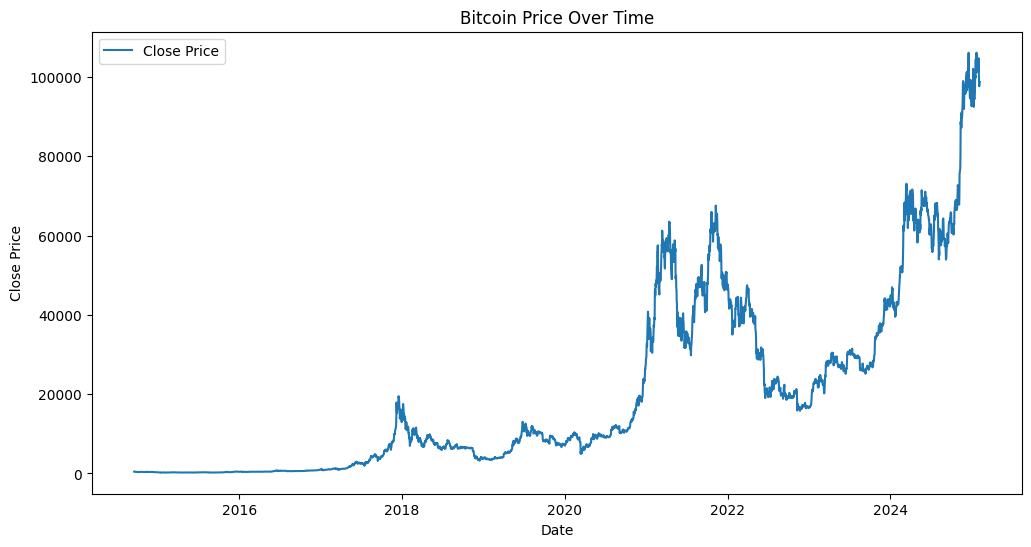

In [5]:
# Plotting the original Close price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label='Close Price')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### 2. Checking for Stationarity

#### Visual Inspection (Rolling Mean & Standard Deviation)

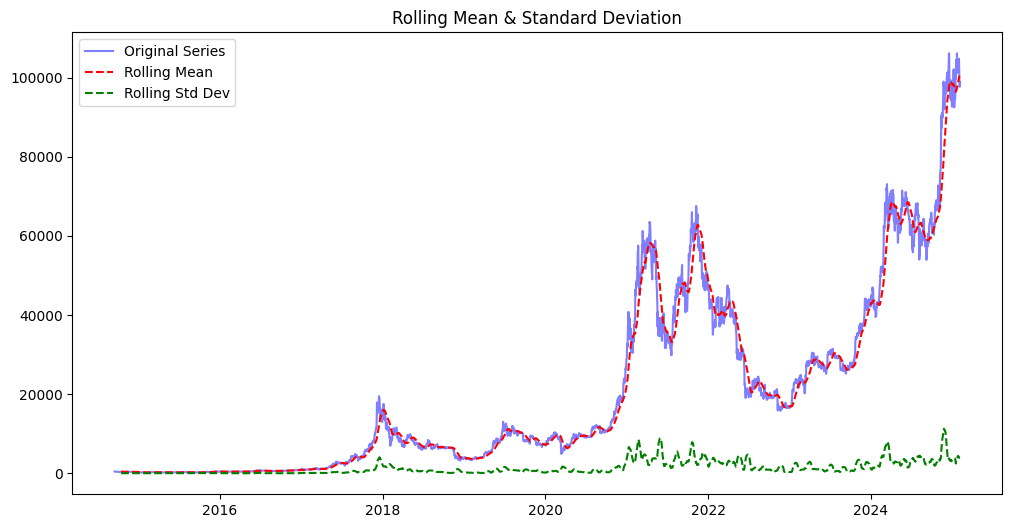

In [ ]:
def plot_rolling_statistics(series, window=30):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, label="Original Series", color="blue", alpha=0.5)
    plt.plot(rolling_mean, label="Rolling Mean", color="red", linestyle="dashed")
    plt.plot(rolling_std, label="Rolling Std Dev", color="green", linestyle="dashed")
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()

# Apply on 'Close' column
plot_rolling_statistics(df['Close'])

The rolling mean and standard deviation fluctuate over time, the data is likely non-stationary.

#### Augmented Dickey-Fuller (ADF) Test:

In [ ]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(df["Close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

ADF Statistic (Original): 0.3608
p-value (Original): 0.9800
Interpretation: The original series is Non-Stationary.



### 3.Differencing to Achieve Stationarity

In [41]:
# Apply first-order differencing
df['Close_Diff'] = df['Close'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(df["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Differenced): -9.2696
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


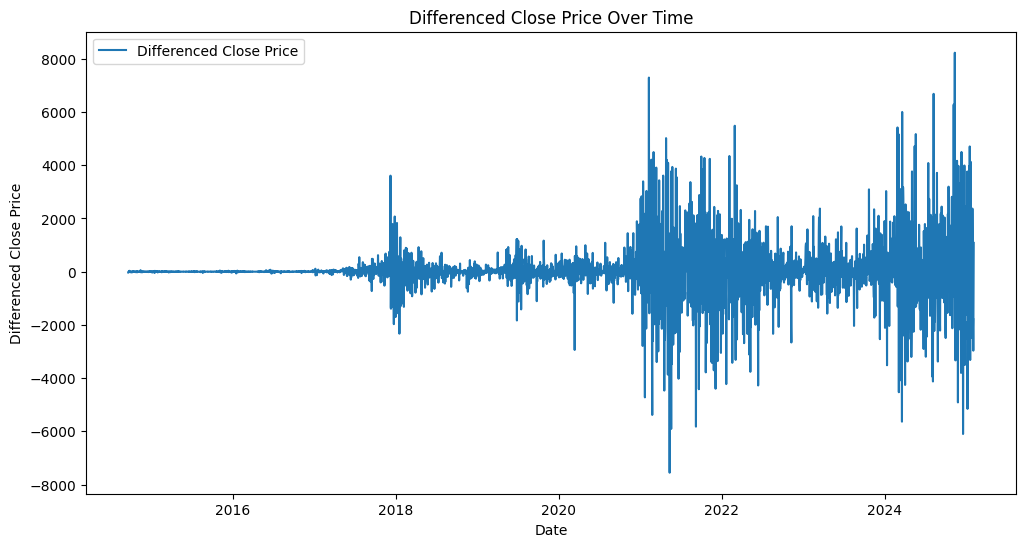

In [7]:
# Plotting the differenced Close price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close_Diff'], label='Differenced Close Price')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

**Stationarity Check Insights**
- Initially, the **Augmented Dickey-Fuller (ADF) test** showed that the series was **non-stationary** (p-value = 0.986).
- After **first-order differencing**, the ADF test confirmed that the series is now **stationary** (ADF Statistic = -9.206, p-value < 0.05).
- This means the differencing step successfully removed trend-related non-stationarity.

### 4. Checking for seasonality using seasonal decomposition


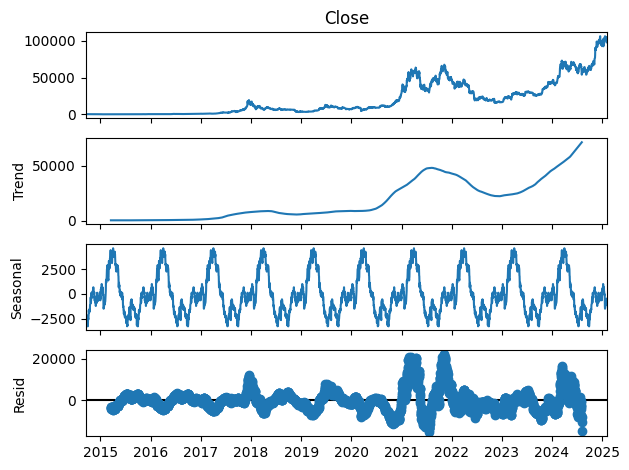

In [ ]:
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)
decomposition.plot()
plt.show()

**Seasonality Detection Insights**
- **Seasonal Decomposition of Time Series (STL Decomposition) was performed.**
- The decomposition shows:
  - A **clear trend component**, indicating long-term upward movement.
  - A **strong seasonal component**, with repeating cycles at regular intervals.
  - The **residual component** contains some noise but no strong patterns.
- **Conclusion**: The data exhibits **seasonality**, meaning a standard ARIMA model may not be sufficient.

**Next Steps**
- Since **seasonality is present**, a **SARIMA (Seasonal ARIMA) model** is a better choice than a standard ARIMA.
- Determine seasonal order `(P, D, Q, s)` using **ACF/PACF plots** and **grid search tuning**.
- Train the SARIMA model and evaluate its performance.

---
📌 **Action Items:**
1. Fine-tune SARIMA hyperparameters.
2. Validate the model using train-test splits or cross-validation.
3. Forecast future values and assess model accuracy.

### 5. Visualize Autocorrelations and Partial Autocorrelations

For ARIMA and SARIMA, the ACF plot helps determine the MA (Moving Average) term, while the PACF plot helps determine the AR (Auto-Regressive) term.

#### Determine (p, d, q) using ACF & PACF

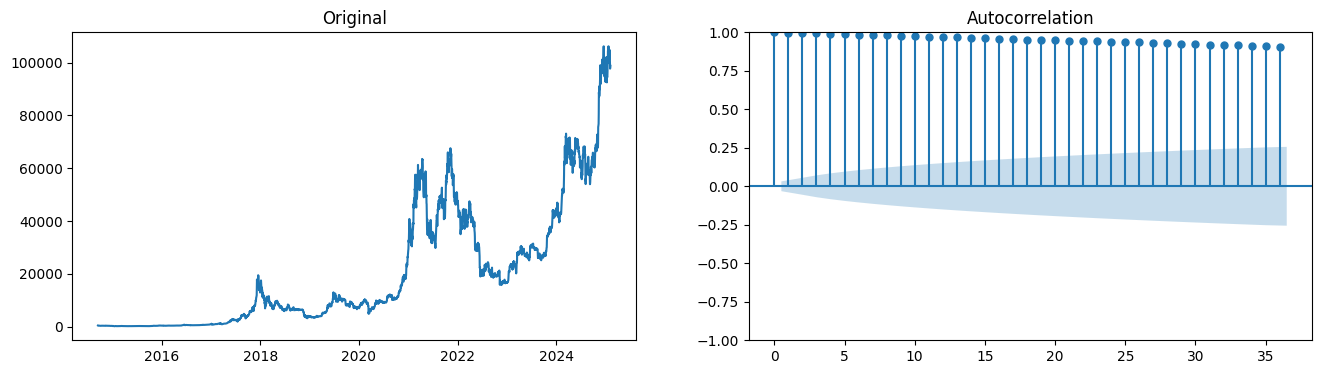

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df.Close)
ax1.set_title('Original')
plot_acf(df.Close, ax=ax2)
ax2.set_title('Autocorrelation')

plt.show()

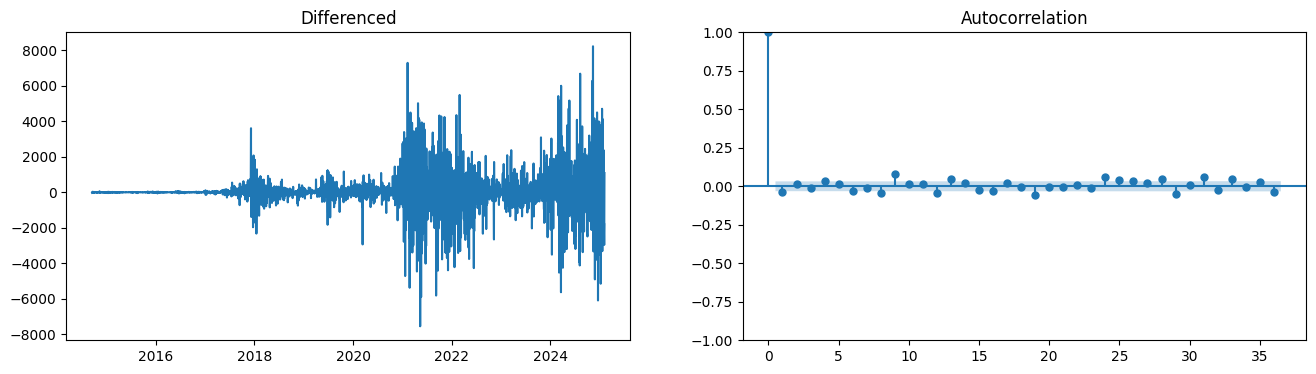

In [9]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Differenced')
plot_acf(diff, ax=ax2);

In [ ]:
ndiffs(df.Close, test='adf')

1

**p**

p is the order of the Auto Regressive(AR) term. It refers to the number of lags to be used as predictors.

We can find the required number of AR terms by inspecting the PACF plot

The partial autocorrelation represents the correlation between the series and its lags

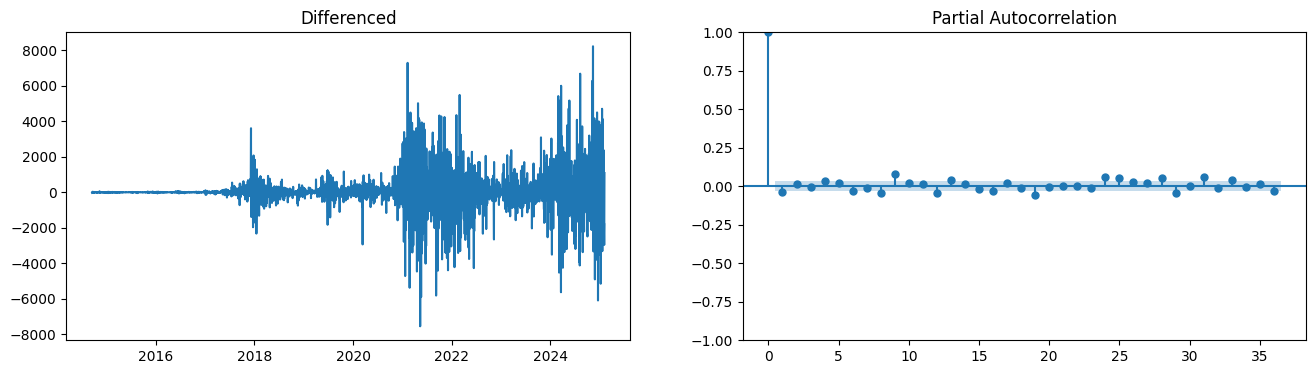

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Differenced')
plot_pacf(diff, ax=ax2);

**Analysis from ACF and PACF**  

- **ACF** shows a sharp drop after lag 1 → suggests **MA(1)** (Moving Average order = 1).  
- **PACF** cuts off after lag 1 → suggests **AR(1)** (Autoregressive order = 1).  
- The data has been differenced and confirmed to be stationary (**ADF test p-value < 0.05**), meaning **first-order differencing (d = 1) was required**.  

**ARIMA Model: ARIMA(1,1,1)**  
- **p = 1** (Autoregressive component from PACF)  
- **d = 1** (First-order differencing to ensure stationarity)  
- **q = 1** (Moving Average component from ACF)  

Since differencing was required to make the data stationary, an **ARIMA(1,1,1) model** is the best fit instead of ARMA(1,1), which is used for already stationary series (**d = 0**).


## Model Selection and Fitting (ARIMA/SARIMA)

### ARIMA Model:

In [44]:
# Set frequency to daily ('D') or the appropriate frequency based on your data
df = df.asfreq('D')

In [45]:
# Fit ARIMA(1,1,1) model
model = ARIMA(train["Close"], order=(1,1,1))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [46]:
#print summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3034
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -24555.252
Date:                Tue, 04 Feb 2025   AIC                          49116.503
Time:                        19:47:50   BIC                          49134.555
Sample:                    09-17-2014   HQIC                         49122.993
                         - 01-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0675      0.351     -0.192      0.848      -0.756       0.621
ma.L1          0.0420      0.352      0.119      0.905      -0.648       0.732
sigma2      6.313e+05   5332.544    118.382      0.0

## Issues Identified in the ARIMA(1,1,1) Model

- **AR and MA Coefficients Are Close to Zero**
  - `ar.L1 = -0.0675` (very small, almost negligible)
  - `ma.L1 = 0.0420` (also very small)
  - *Implication:* The model isn't capturing meaningful patterns in the data.

- **High Variance (`sigma2`)**
  - `sigma2 = 6.313e+05` (large value)
  - *Implication:* Indicates that residual errors have high variance, suggesting that the model is not stable.

- **Ljung-Box Test (`Prob(Q) = 1.00`)**
  - *Implication:* The residuals are not white noise. This suggests that the model is likely missing some important lags or seasonal effects.

- **High Heteroskedasticity (`H = 1921.20`)**
  - *Implication:* Indicates non-constant variance in the residuals, meaning the model is not handling fluctuations well.

### Make time series predictions

<Axes: title={'center': 'Density'}, ylabel='Density'>

<Figure size 1400x700 with 0 Axes>

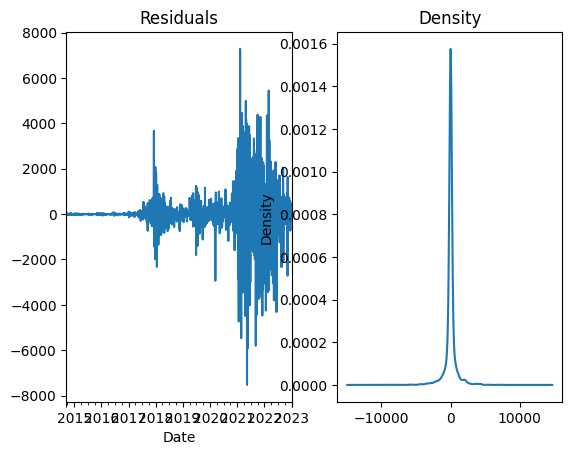

In [34]:
plt.figure(figsize=(14, 7))
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])

In [47]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

In [49]:
# Convert differenced predictions back to actual values
forecast_cumsum = forecast.cumsum() + train["Close"].iloc[-1]

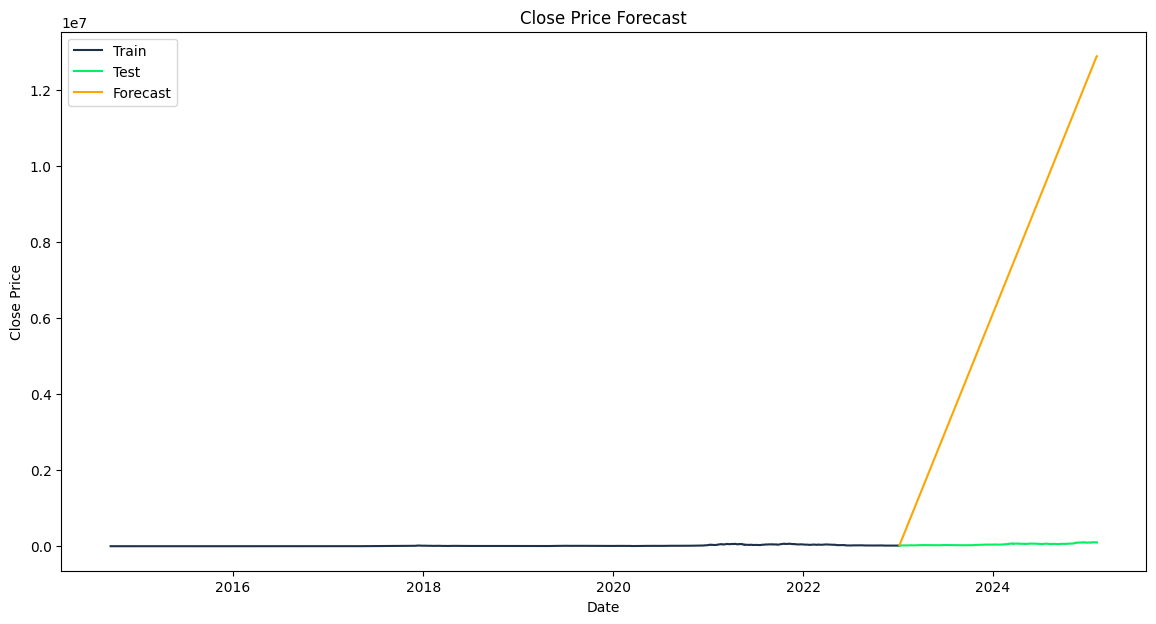

In [50]:
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast_cumsum, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test["Close"], forecast))

# Print RMSE
print(f'RMSE: {rmse}')

ValueError: Found input variables with inconsistent numbers of samples: [759, 365]

## SARIMA

**SARIMA=ARIMA Model+Seasonal AR Terms+Seasonal MA Terms+Seasonal Differencing **

Extends ARIMA by adding seasonal components:
Seasonal AR and MA terms capture patterns that repeat over a fixed period (e.g., monthly, yearly).

Seasonal differencing removes repeating seasonal trends.

In [ ]:
# Fit SARIMA model
sarima_model = SARIMAX(df['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Model summary
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 3793
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -31395.420
Date:                            Tue, 04 Feb 2025   AIC                          62800.840
Time:                                    12:56:38   BIC                          62832.028
Sample:                                09-18-2014   HQIC                         62811.927
                                     - 02-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      0.498     -2.006      0.045      -1.977      -0.023
ma.L1          0.9999      0.429   

### Forecasting:

In [ ]:
# Forecast for the next 10 periods
forecast = sarima_result.forecast(steps=10)
print(forecast)

2025-02-05    98746.204820
2025-02-06    98690.403282
2025-02-07    98749.973526
2025-02-08    98869.033241
2025-02-09    98891.801896
2025-02-10    98847.605279
2025-02-11    98837.131491
2025-02-12    98957.471927
2025-02-13    99074.188064
2025-02-14    99256.892437
Freq: D, Name: predicted_mean, dtype: float64


### Plot Forecasts

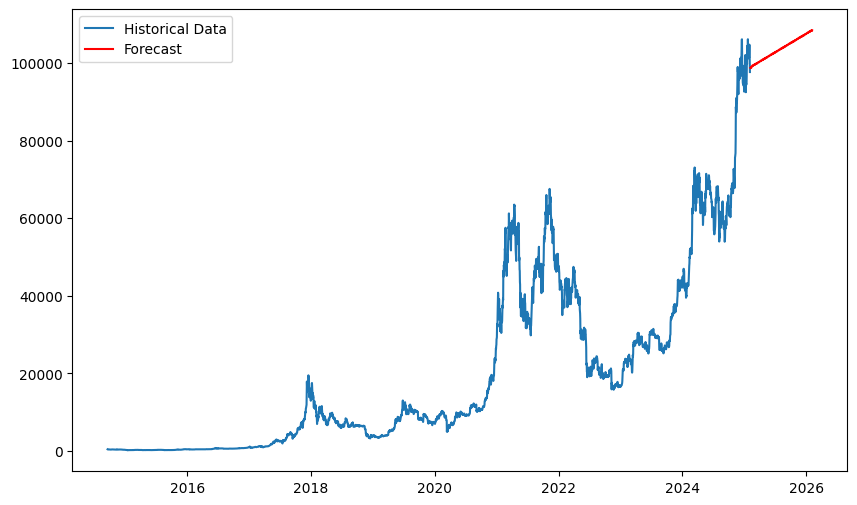

In [ ]:
# Define forecast steps (number of periods you want to forecast)
forecast_steps = 365

# Generate the forecast
forecast = sarima_result.forecast(steps=forecast_steps)

# Create a new index for the forecast (adjust frequency based on your data's frequency)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq=df.index.freq)[1:]

# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Historical Data')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

## Evaluate Model Performance

In [ ]:
# Get in-sample predictions from the SARIMA model
df['ARIMA_Pred'] = sarima_result.predict(start=0, end=len(df)-1)

# Drop rows with NaN values in either 'Close' or 'ARIMA_Pred'
df_clean_arima = df.dropna(subset=['Close', 'ARIMA_Pred'])

# Compute Mean Absolute Error (MAE)
mae_arima = mean_absolute_error(df_clean_arima['Close'], df_clean_arima['ARIMA_Pred'])

# Compute Root Mean Squared Error (RMSE)
mse_arima = mean_squared_error(df_clean_arima['Close'], df_clean_arima['ARIMA_Pred'])
rmse_arima = np.sqrt(mse_arima)

# Print the error metrics for SARIMA
print(f"ARIMA Mean Absolute Error (MAE): {mae_arima}")
print(f"ARIMA Root Mean Squared Error (RMSE): {rmse_arima}")

ARIMA Mean Absolute Error (MAE): 473.64919812211895
ARIMA Root Mean Squared Error (RMSE): 962.0998387592215


In [ ]:
# Get in-sample predictions from the SARIMA model
df['SARIMA_Pred'] = sarima_result.predict(start=0, end=len(df)-1)

# Drop rows with NaN values in either 'Close' or 'SARIMA_Pred'
df_clean_sarima = df.dropna(subset=['Close', 'SARIMA_Pred'])

# Compute Mean Absolute Error (MAE)
mae_sarima = mean_absolute_error(df_clean_sarima['Close'], df_clean_sarima['SARIMA_Pred'])

# Compute Root Mean Squared Error (RMSE)
mse_sarima = mean_squared_error(df_clean_sarima['Close'], df_clean_sarima['SARIMA_Pred'])
rmse_sarima = np.sqrt(mse_sarima)

# Print the error metrics for SARIMA
print(f"SARIMA Mean Absolute Error (MAE): {mae_sarima}")
print(f"SARIMA Root Mean Squared Error (RMSE): {rmse_sarima}")

SARIMA Mean Absolute Error (MAE): 473.64919812211895
SARIMA Root Mean Squared Error (RMSE): 962.0998387592215


### Hyperparameter tuning

In [ ]:
# Use auto_arima to automatically tune the SARIMA model.
# Adjust 'm' (seasonal period) as per your data frequency (e.g., m=12 for monthly data with yearly seasonality).
auto_model = pm.auto_arima(
    df['Close'],
    seasonal=True,
    m=12,               # seasonal period, adjust if needed
    start_p=0,
    start_q=0,
    max_p=2,
    max_q=2,
    d=None,             # let auto_arima determine the order of differencing
    start_P=0,
    start_Q=0,
    max_P=1,
    max_Q=1,
    D=None,             # let auto_arima determine the seasonal differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

ValueError: Input contains NaN.

In [ ]:
# Generate in-sample predictions
# Note: 'predict_in_sample' gives predictions for the training data.
df['SARIMA_Pred'] = auto_model.predict_in_sample(start=0, end=len(df) - 1)

# Calculate error metrics
mae = mean_absolute_error(df['Close'], df['SARIMA_Pred'])
mse = mean_squared_error(df['Close'], df['SARIMA_Pred'])
rmse = np.sqrt(mse)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

### Forecast Future Values

In [ ]:
# Forecasting the next 12 periods
n_periods = 12
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Create an index for the forecasted periods
# (adjust this to suit your DataFrame's datetime index or desired index)
forecast_index = pd.date_range(start=df.index[-1], periods=n_periods+1, freq='M')[1:]

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
}, index=forecast_index)

print(forecast_df)